In [15]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np


def get_device() -> torch.device:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    x = torch.ones(1, device=device)

    return device


def get_data() -> datasets.MNIST:
    transform = transforms.Compose(
        [
            # Converts to float and normalizes from [0, 255] to [0, 1]
            transforms.ToTensor(),
            # Flattens the 2D image 28x28 to 1D vector 784
            transforms.Lambda(lambda x: x.view(-1)),
        ]
    )

    train_set = datasets.MNIST("data/", download=True, train=True, transform=transform)
    return train_set


def batch_accuracy(x: torch.Tensor, y: torch.Tensor, model: nn.Module):
    """Compute accuracy for a batch of inputs"""
    model.eval()
    with torch.no_grad():
        predictions = model(x)
    return (predictions.argmax(dim=1) == y).cpu()


class RobustnessStats:
    def __init__(self, device: torch.device):
        self.error_sums = torch.zeros((10, 28, 28), device=device)
        self.class_robustness = torch.zeros(10, device=device)
        self.incorrect = 0
        self.robust = 0
        self.not_robust = 0


def calc_robustness_stats(model: nn.Module) -> RobustnessStats:
    device = get_device()
    model.eval()
    model = model.to(device)
    train_data = get_data()
    stats = RobustnessStats(device)

    # Create DataLoader for batch processing
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=False)

    # Process batches with progress bar
    for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        labels = labels.to(device)

        # Check which samples are correctly classified
        correct_mask = batch_accuracy(images, labels, model)

        # Process only correctly classified samples
        correct_images = images[correct_mask]
        correct_labels = labels[correct_mask]
        stats.incorrect += len(images) - len(correct_images)

        if len(correct_images) > 0:
            # Create all possible single-pixel perturbations
            pixel_perturbations = torch.eye(784, device=device)
            perturbed_images = correct_images.unsqueeze(
                1
            ) + pixel_perturbations.unsqueeze(0) * (1 - 2 * correct_images.unsqueeze(1))

            # Reshape for batch processing
            batch_labels = correct_labels.repeat_interleave(784)
            perturbed_images = perturbed_images.reshape(-1, 784)

            # Process perturbations in sub-batches to avoid memory issues
            sub_batch_size = 784
            for i in range(0, len(perturbed_images), sub_batch_size):
                sub_batch = perturbed_images[i : i + sub_batch_size]
                sub_labels = batch_labels[i : i + sub_batch_size]

                # Check which perturbations cause misclassification
                errors = ~batch_accuracy(sub_batch, sub_labels, model)

                # Update error sums
                error_indices = torch.nonzero(errors)
                error_count = len(error_indices)
                if error_count == 0:
                    stats.robust += 1
                else:
                    stats.not_robust += 1
                if len(error_indices) > 0:
                    sample_idx = error_indices // 784
                    pixel_idx = error_indices % 784
                    labels_to_update = correct_labels[sample_idx]
                    stats.error_sums[
                        labels_to_update, pixel_idx // 28, pixel_idx % 28
                    ] += 1
    # Calculate class robustness: 1 - (#errors / #possible mistakes) for each class
    # #possible mistakes = (#correctly classified samples of class) * 784
    class_counts = torch.zeros(10, device=device)
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        correct_mask = batch_accuracy(images, labels, model)
        correct_labels = labels[correct_mask]
        for c in range(10):
            class_counts[c] += (correct_labels == c).sum()
    possible_mistakes = class_counts * 784
    total_errors_per_class = stats.error_sums.view(10, -1).sum(dim=1)
    # Avoid division by zero
    stats.class_robustness = torch.where(
        possible_mistakes > 0,
        1 - (total_errors_per_class / possible_mistakes),
        torch.zeros_like(possible_mistakes),
    )
    return stats


def plot_overall_robustness(incorrect: int, robust: int, not_robust: int) -> None:
    counts = [incorrect, robust, not_robust]
    labels = ["Falsch Klassifiziert", "Robust", "Nicht Robust"]
    colors = ["#ff9999", "#66b3ff", "#99ff99"]

    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=labels, autopct="%1.1f%%", colors=colors, startangle=140)
    plt.ylim(1)
    plt.show()

def plot_class_robustness(class_robustness: np.ndarray) -> None:
    plt.figure(figsize=(8, 5))
    plt.bar(range(10), class_robustness, color="#66b3ff")
    plt.xlabel("Digit Klasse")
    plt.ylabel("Robustheit")
    plt.title("Robustheit pro Klasse")
    plt.xticks(range(10))
    plt.ylim(0, 1)
    y_vals = class_robustness ** 100
    plt.bar(range(10), y_vals, color="#ffcc99", alpha=0.5)
    plt.show()

def plot_error_heatmaps(error_sums: np.ndarray) -> None:
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(10):
        ax = axes[i // 5, i % 5]
        im = ax.imshow(error_sums[i], interpolation="nearest")
        ax.set_title(f"Digit {i}")
    plt.colorbar(im, ax=axes.ravel().tolist())
    plt.tight_layout()
    plt.show()

def plot_stats(stats: RobustnessStats) -> None:
    plot_overall_robustness(stats.incorrect, stats.robust, stats.not_robust)
    plot_class_robustness(stats.class_robustness.cpu().numpy())
    plot_error_heatmaps(stats.error_sums.cpu().numpy())

class CombinedModel(nn.Module):
    def __init__(self, model_a: nn.Module, model_b: nn.Module, a_robustness: np.ndarray, b_robustness: np.ndarray):
        super(CombinedModel, self).__init__()
        self.model_a = model_a
        self.model_b = model_b
        self.a_robustness = a_robustness
        self.b_robustness = b_robustness
    
    def forward(self, x): 
        result_a = self.model_a(x)
        result_b = self.model_b(x)
        # Amplify robustness differences to make them matter more
        a_robustness = self.a_robustness ** 50
        b_robustness = self.b_robustness ** 50
        # Normalize robustness scores to sum to 1 for each class
        a_weights = a_robustness / (a_robustness + b_robustness + 1e-8)
        b_weights = b_robustness / (a_robustness + b_robustness + 1e-8)
        # Expand weights to match batch size
        a_weights = torch.tensor(a_weights, device=x.device).unsqueeze(0).expand_as(result_a)
        b_weights = torch.tensor(b_weights, device=x.device).unsqueeze(0).expand_as(result_b)
        # Weighted sum of logits
        return result_a * a_weights + result_b * b_weights


In [16]:
model_a = torch.load("Davids_MNIST_Model.pt", weights_only=False)
model_a_stats = calc_robustness_stats(model_a)
model_b = torch.load("Davids_MNIST_Model_3.pt", weights_only=False)
model_b_stats = calc_robustness_stats(model_b)

100%|██████████| 938/938 [02:08<00:00,  7.28it/s]


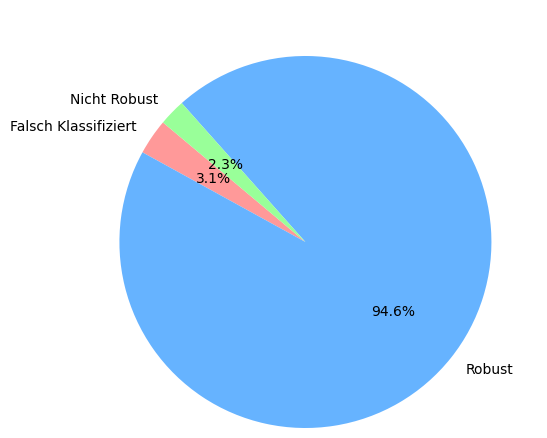

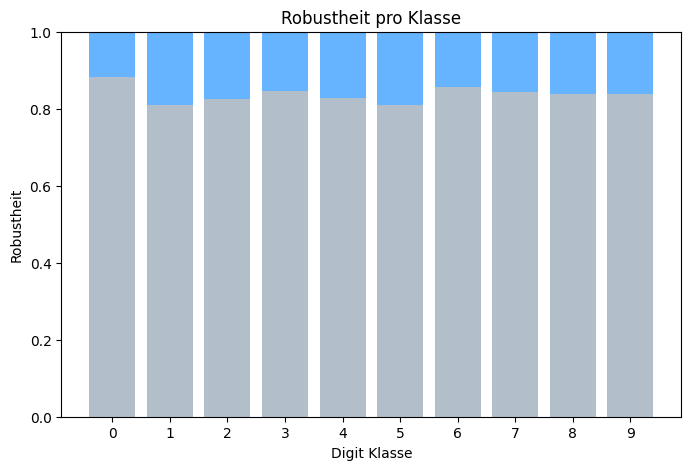

C:\Users\arthu\AppData\Local\Temp\ipykernel_21776\1725766473.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


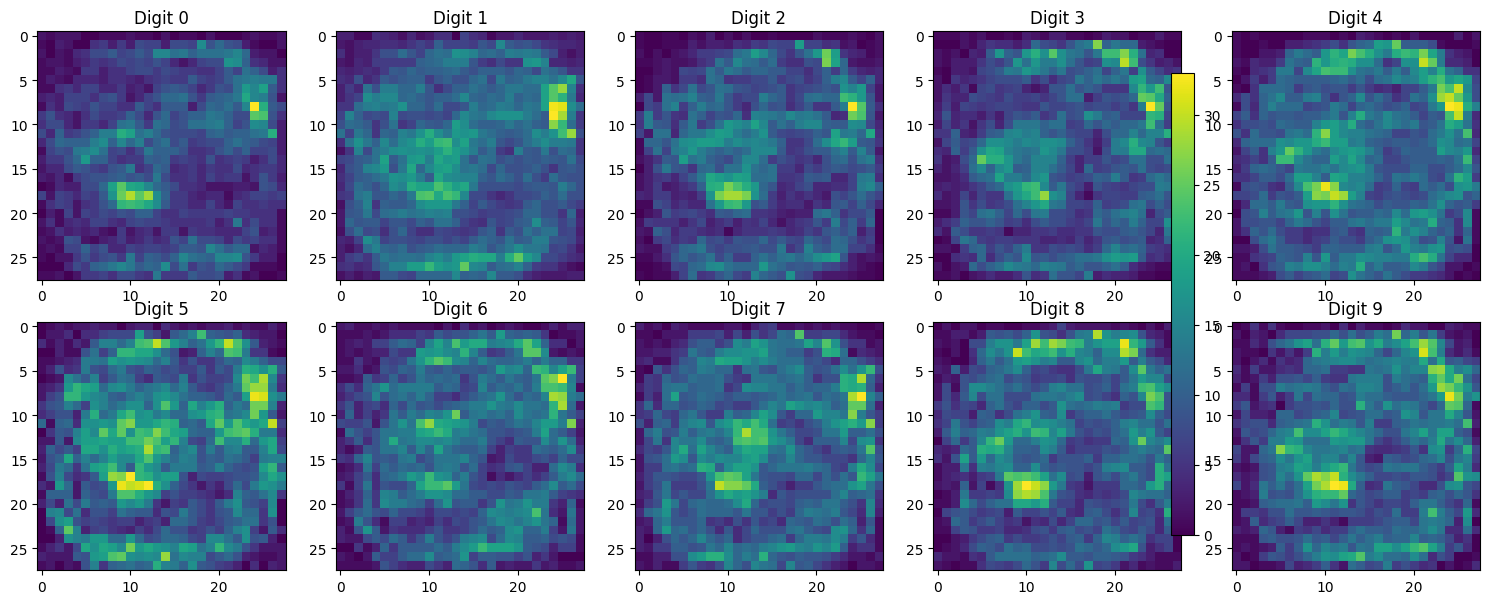

In [17]:
plot_stats(model_a_stats)

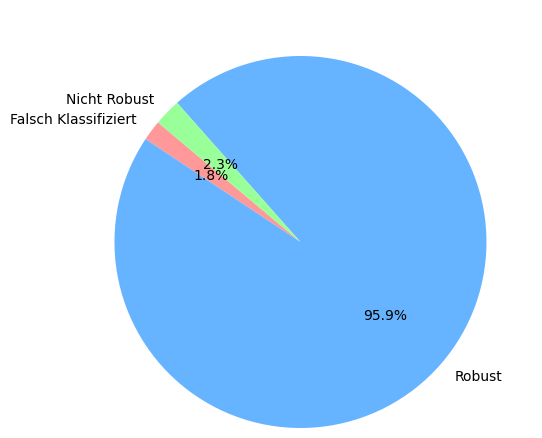

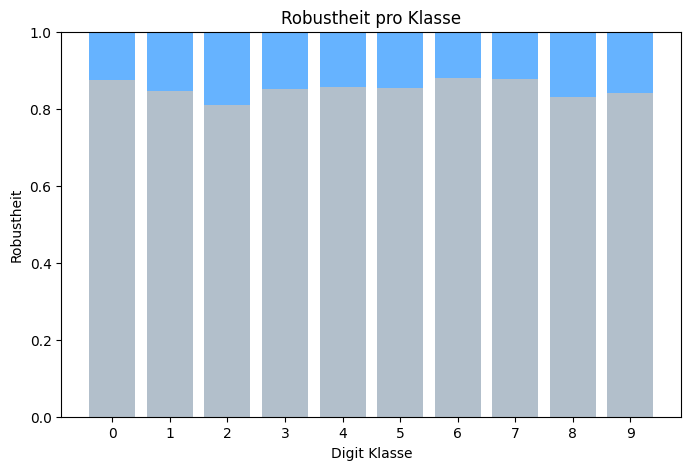

C:\Users\arthu\AppData\Local\Temp\ipykernel_21776\1725766473.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


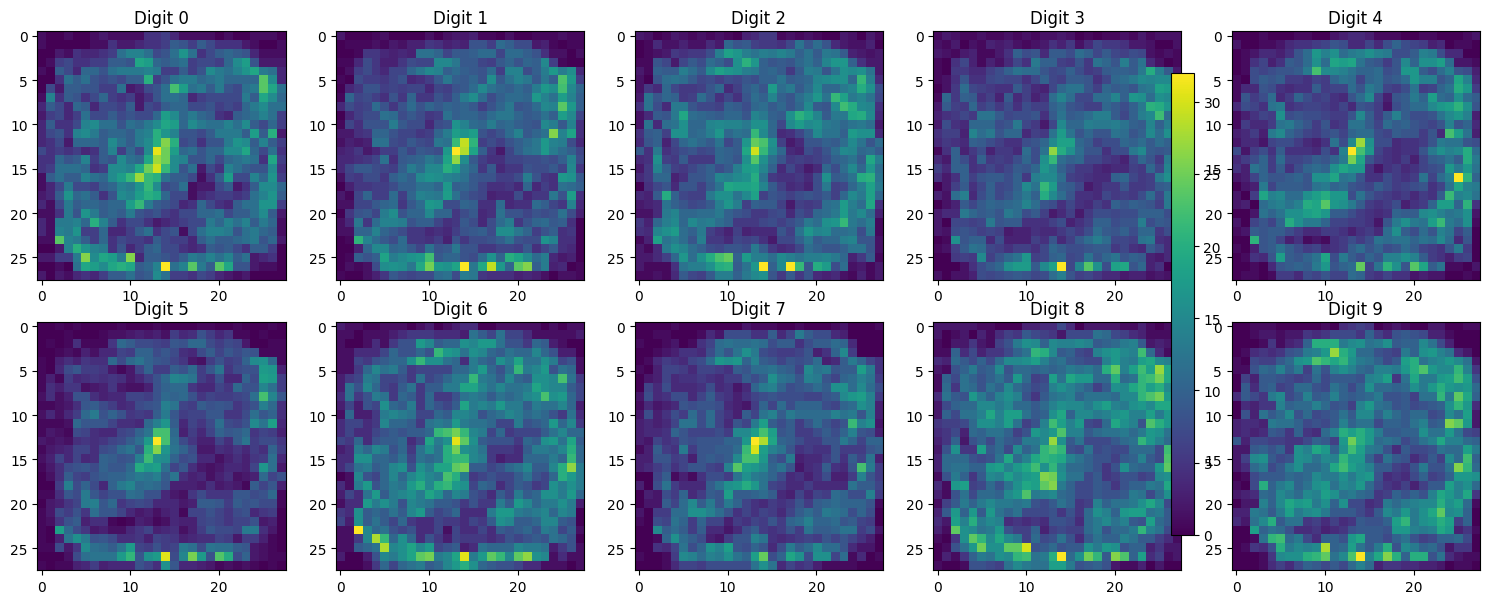

In [18]:
plot_stats(model_b_stats)

  0%|          | 0/938 [00:00<?, ?it/s]C:\Users\arthu\AppData\Local\Temp\ipykernel_21776\1725766473.py:185: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_weights = torch.tensor(a_weights, device=x.device).unsqueeze(0).expand_as(result_a)
C:\Users\arthu\AppData\Local\Temp\ipykernel_21776\1725766473.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_weights = torch.tensor(b_weights, device=x.device).unsqueeze(0).expand_as(result_b)
100%|██████████| 938/938 [02:55<00:00,  5.36it/s]


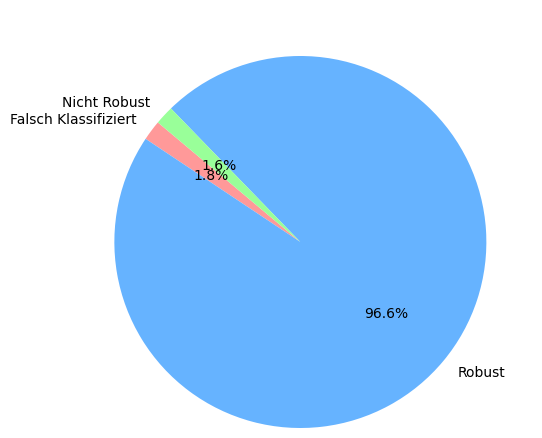

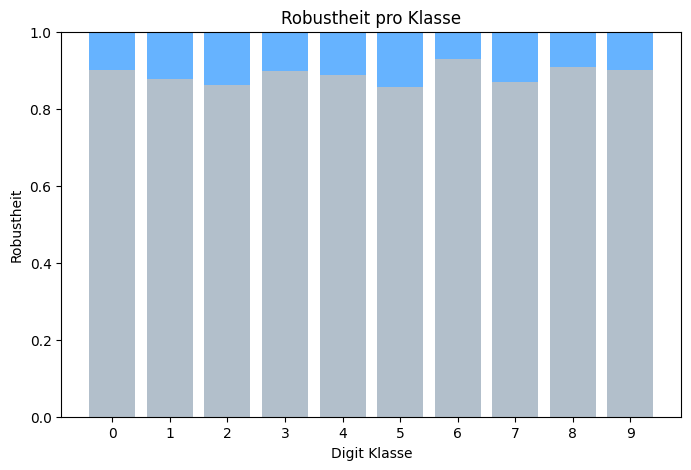

C:\Users\arthu\AppData\Local\Temp\ipykernel_21776\1725766473.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


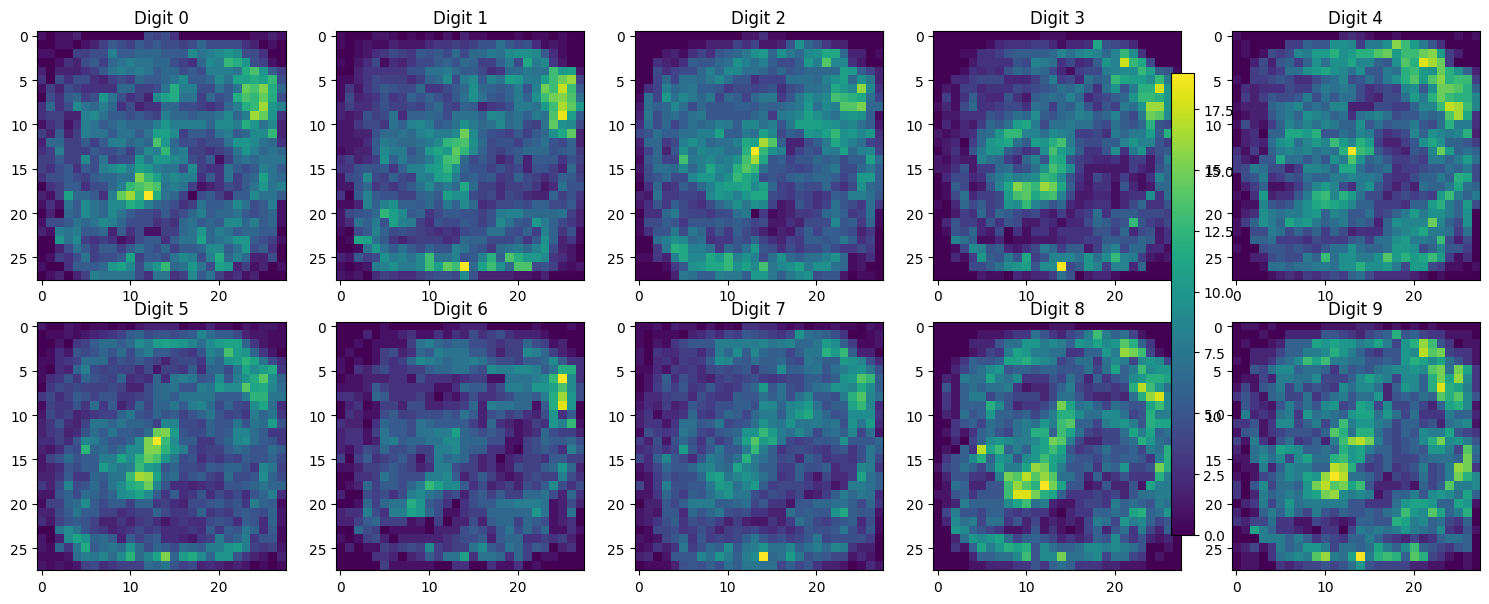

In [19]:
combined_model = CombinedModel(
    model_a, model_b, model_a_stats.class_robustness, model_b_stats.class_robustness
)
combined_model_stats = calc_robustness_stats(combined_model)
plot_stats(combined_model_stats)